# 模型选择、欠拟合和过拟合

通过多项式拟合来探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
from d2l.torch import Accumulator, Animator, accuracy

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [3]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

查看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.3784],
         [-0.3492]]),
 tensor([[ 1.0000e+00,  3.7837e-01,  7.1581e-02,  9.0281e-03,  8.5398e-04,
           6.4624e-05,  4.0753e-06,  2.2028e-07,  1.0418e-08,  4.3800e-10,
           1.6573e-11,  5.7005e-13,  1.7974e-14,  5.2314e-16,  1.4139e-17,
           3.5664e-19,  8.4338e-21,  1.8771e-22,  3.9458e-24,  7.8577e-26],
         [ 1.0000e+00, -3.4915e-01,  6.0953e-02, -7.0939e-03,  6.1921e-04,
          -4.3240e-05,  2.5162e-06, -1.2550e-07,  5.4775e-09, -2.1250e-10,
           7.4193e-12, -2.3549e-13,  6.8519e-15, -1.8403e-16,  4.5895e-18,
          -1.0683e-19,  2.3312e-21, -4.7879e-23,  9.2872e-25, -1.7066e-26]]),
 tensor([5.2141, 4.5263]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正常)

weight: [[ 4.9841924  1.2192118 -3.3916903  5.5852265]]


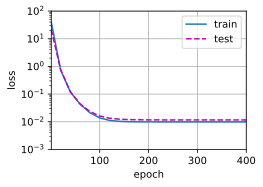

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.2280388 5.406538 ]]


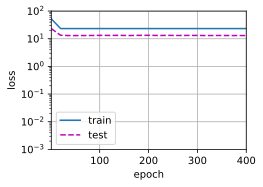

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 4.999662    1.2822455  -3.440043    5.2978635  -0.01452459  0.7825511
   0.68608195  0.08694682  0.26273006 -0.14024065  0.15572627  0.19908029
   0.15773451  0.10237098  0.09752451 -0.15156062 -0.05802879  0.15229036
  -0.06945468  0.05432681]]


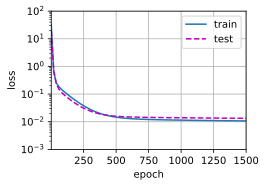

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)